# Balsam Tutorial
----

## Tutorial Setup

Once you have setup your conda environment:
```bash
source setup.sh --site [local, ALCF, NERSC or OLCF]
```

Follow the tutorial either via by executing the scripts provided in the repo, or via the Jupyter notebook.

To execute the scripts, run them in order as we progress:

```python 
python 0_application.py
python 1_define_jobs.py
python 2_submit_jobs.py
```

To open the notebook follow the instructions for your site below (you can also run the notebook locally):

### NERSC

Follow this link https://jupyter.nersc.gov/. 

### OLCF and ALCF

Create an ssh tunnel:

step 1: (From your local computer)
```bash
ssh -L 9900:localhost:9900 csimpson@polaris.alcf.anl.gov
```

step 2:
```bash
jupyter notebook --no-browser --port 9900
```

step 3: Open browser on local computer and go to http://localhost:9900/?token=xxxxx

You will likely need to replace 9900 with a different number so as to not select the same port as another workshop participant running this demo.  You can choose any number between 9000 and 65535.

### Local Machine

```bash
jupyter notebook
```
Note that if you run this notebook locally, you will need to have a copy of the LAMMPs input file and environment file on the machine where you are running LAMMPS.


---

# Overview

This tutorial will show you how to setup a Balsam site and run simulations via Balsam. For this tutorial we are using the application `LAMMPS`, a large scale classical molecular dynamics code that stands for Large-scale Atomic/Molecular Massively Parallel Simulator. 

# Setup Balsam site

In terminal log into balsam and create your site in a folder of your choosing:
```bash
balsam login
balsam site init -n <site-name> <site-name>
```

Now start the site:
```bash
cd <site-folder>
balsam site start
cd ..
```

# Create Balsam Application

Save your site name to ```site_name```.
Copy the absolute path to the demo Balsam directory to ```demo_path```.

In [1]:
import os
site_name = "polaris-jointdemos"
demo_path = "/home/csimpson/polaris/DOE-HPC-workflow-training/Balsam" #os.path.abspath("./")
application_env = demo_path+"/Lammps/ALCF/lammps_envs.sh"
input_file_path = demo_path+"/Lammps/lj_lammps_template.in"
application_env

'/home/csimpson/polaris/DOE-HPC-workflow-training/Balsam/Lammps/ALCF/lammps_envs.sh'

We create the application using:
```shell
python 0_application.py
```

In [2]:
from balsam.api import ApplicationDefinition

class Lammps(ApplicationDefinition):

    site = site_name
    
    environment_variables = {"OMP_PROC_BIND":"spread", "OMP_PLACES":"cores"}
            
    def shell_preamble(self):
        return f'source {application_env}'


    command_template = 'lmp -in {{input_file_path}} -k on g {{NGPUS}} -var tinit {{tinit}} -var lat_scale {{lat_scale}} -sf kk -pk kokkos neigh half neigh/qeq full newton on'
    
        
    def postprocess(self):
        print("starting postprocess")
        try:
            with open("energy.dat","r") as f:
                for line in f:
                    pass
                line_entries = line.split()
                if line_entries[0] == "1000":
                    self.job.data = {"tfinal":float(line_entries[3]), "efinal":float(line_entries[1])+float(line_entries[2]), "Pfinal":float(line_entries[4])}
                    self.job.state = "POSTPROCESSED"
                else:
                    self.job.state = "FAILED"
                    self.job.state_data = {"reason": "Final step not reached"}
        except Exception as e:
            self.job.state = "FAILED"
            self.job.state_data = {"reason": str(e)}        

Lammps.sync()

# Create Balsam Jobs

Then we create the Balsam Jobs via this script:

```python
python 1_define_jobs.py 
```

In [10]:
from balsam.api import Job
import numpy as np

n_gpus = 4 

#initial_temps = np.arange(0.72,2.16,0.12)
lattices = np.arange(0.15,0.85,0.05)

jobs = [Job(app_id="Lammps",
            site_name=site_name,
            workdir=f"LJ/{n}",
            parameters={"NGPUS": n_gpus,"tinit":1.5, "lat_scale": lat_scale,"input_file_path":input_file_path},
            num_nodes=1,
            ranks_per_node=n_gpus,
            gpus_per_rank=1,
            threads_per_rank=8, #This sets OMP_NUM_THREADS
            launch_params={"cpu_bind":"depth"},
            tags={"parameter_test":"density"},
        )
        for n,lat_scale in enumerate(lattices)]

jobs = Job.objects.bulk_create(jobs)

# Submit Balsam Jobs

Then we submit the Balsam jobs to our site via:

```shell
python submit_jobs.py <site-name> [optional GPU=True]
```


In [4]:
from balsam.api import BatchJob, Site

site_name = site_name
site = Site.objects.get(site_name)

BatchJob.objects.create(
    site_id=site.id,
    num_nodes=2,
    wall_time_min=10,
    job_mode="mpi",
    project="WALSforAll",
    queue="debug",
)

BatchJob(num_nodes=2, wall_time_min=10, job_mode=mpi, optional_params={}, filter_tags={}, partitions=None, id=11935, site_id=492, scheduler_id=None, project=WALSforAll, queue=debug, state=pending_submission, status_info={}, start_time=None, end_time=None)

# Plot Results

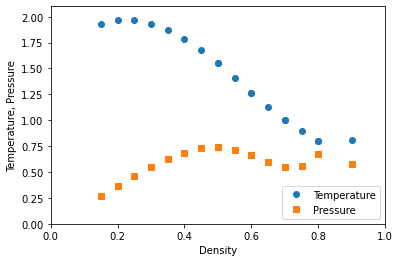

In [122]:
import matplotlib.pyplot as plt

finished_jobs = Job.objects.filter(state="JOB_FINISHED",site_id=site.id,tags={"parameter_test":"lat"})

if finished_jobs.count() > 0:
    efinal = []
    tfinal = []
    density = []
    Pfinal = []
    tinit = []
    for j in finished_jobs:

        efinal.append(j.data['efinal'])
        tfinal.append(j.data['tfinal'])
        Pfinal.append(j.data['Pfinal'])
        density.append(j.get_parameters()['lat_scale'])
        tinit.append(j.get_parameters()['tinit'])

    plt.plot(density,tfinal,'o',label="Temperature")
    plt.plot(density,Pfinal,'s',label="Pressure")
    plt.ylim(0,2.1)
    plt.xlim(0,1)
    plt.ylabel("Temperature, Pressure")
    plt.xlabel("Density")
    plt.legend(loc=0)
    plt.savefig("lammps_phases.png")

# Job Dependencies and Multi-site workloads

Now we will show how to create dependencies between jobs and how to deploy those jobs across multiple machines.  

We have already run several Lammps jobs on Polaris.  We will now create a job that is dependent on the outcome of those jobs that will run on Perlmutter.  The dependent job will fit a spline curve to the data plotted in the last section. 

To create the spline fitting application on Perlmutter we must first create and start a site on Perlmutter.  We leave that as an exercise to the simulator, but the steps to create the site are identical to the steps outlined at the top of this notebook.

This is the application definition:

In [120]:
site_name = "polaris-jointdemos"

from balsam.api import ApplicationDefinition

class FitSpline(ApplicationDefinition):

    site = site_name
    
    
    def preprocess(self):
        try:
            parent_density = [ j.get_parameters()["lat_scale"]
                for j in self.job.parent_query()]
            parent_tfinal = [ j.data["tfinal"]
                for j in self.job.parent_query()]
            self.job.data={"density":parent_density,"tfinal":parent_tfinal}
        
            self.job.state = "PREPROCESSED"
        except Exception as e:
            self.job.state_data={"reason":str(e)}
            self.job.state = "FAILED"
        
    
    # This routine demonstrates an alternative way of defining an application.  This method, using the function run,
    # wraps around python code. Instead of the command_template, the executable is `python run()`.  
    # The function run will be run on the compute nodes just like command_template.
    def run(self):
        from scipy.interpolate import CubicSpline
        import numpy as np
        
        isort = np.argsort(self.job.data['density'])
        x = np.array(self.job.data['density'])[isort]
        y = np.array(self.job.data['tfinal'])[isort]
        cs = CubicSpline(x,y) 
        
        # Run applications can return objects that can be accessed later through the job instance.
        return cs    

FitSpline.sync()

We want the job we create with FitSpline to use the data from a specific set of jobs and we only want it to execute after those jobs have successfully finished.  We introduce this dependency through the ``parent_ids`` keyword that makes this job dependent on it's parents.

In [111]:
lammps_job_ids = [job.id for job in jobs]
fitting_job = FitSpline.submit(workdir="LJ/spline", parent_ids=lammps_job_ids)

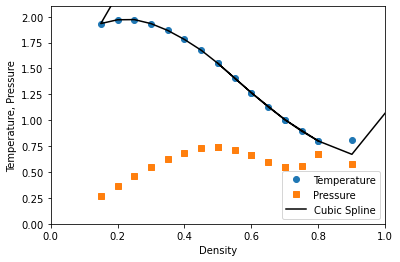

In [112]:
if fitting_job.result():
    cs = fitting_job.result()
    plt.plot(density,tfinal,'o',label="Temperature")
    plt.plot(density,Pfinal,'s',label="Pressure")
    plt.plot(density, cs(density), label='Cubic Spline',c='k')
    plt.ylim(0,2.1)
    plt.xlim(0,1)
    plt.ylabel("Temperature, Pressure")
    plt.xlabel("Density")
    plt.legend(loc=0)